# Assignment 1

## Data Preprocessing

### Imports

In [1]:
import os
import requests
import zipfile
from tqdm import tqdm
import time
import datetime
from IPython.display import display

from typing import List, Dict, Tuple, Sequence

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import gensim
import gensim.downloader as gloader
assert int(gensim.__version__.split('.')[0]) >= 4, "Install gensim 4.x.x or above (pip install -U gensim)"

%matplotlib inline

BATCH_SIZE = 128

### Downloading the Dataset

In [2]:
ROOT_PATH = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(ROOT_PATH, 'data')

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    final_path = os.path.join(data_path, 'dependency_treebank.zip')
    url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(final_path):
        print("Downloading dataset...")
        with requests.Session() as current_session:
            response = current_session.get(url, stream=True)
        save_response_content(response, final_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(final_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data(DATA_PATH)

# The new data path is:
DATA_PATH = os.path.join(DATA_PATH, 'dependency_treebank')

### Dataset Exploration

The dataset is composed of several files whose naming convention is `wsj_{num}.dp`. We explore the content of the first file:

In [3]:
with open(os.path.join(DATA_PATH, 'wsj_0001.dp'), 'r') as f:
    lines = [l.rstrip() for l in f.readlines()]

print(lines)

['Pierre\tNNP\t2', 'Vinken\tNNP\t8', ',\t,\t2', '61\tCD\t5', 'years\tNNS\t6', 'old\tJJ\t2', ',\t,\t2', 'will\tMD\t0', 'join\tVB\t8', 'the\tDT\t11', 'board\tNN\t9', 'as\tIN\t9', 'a\tDT\t15', 'nonexecutive\tJJ\t15', 'director\tNN\t12', 'Nov.\tNNP\t9', '29\tCD\t16', '.\t.\t8', '', 'Mr.\tNNP\t2', 'Vinken\tNNP\t3', 'is\tVBZ\t0', 'chairman\tNN\t3', 'of\tIN\t4', 'Elsevier\tNNP\t7', 'N.V.\tNNP\t12', ',\t,\t12', 'the\tDT\t12', 'Dutch\tNNP\t12', 'publishing\tVBG\t12', 'group\tNN\t5', '.\t.\t3']


Each file contains a paragraph of text, optionally composed of multiple sentences. 

The paragraph is structured as a sequence of lines, each line containing a word, a tag and a number separated by `\t` tags. We don't care about the number, so we ignore the third element.

We can define a function that given a file processes its content and returns a Pandas `DataFrame` for each sentence extracted from the file.

In [4]:
def process_file(filepath: str):
    with open(filepath, 'r') as f:
        # They are not technically csv files, but they are text files
        # so we can still use the same function.
        df = pd.read_csv(f, sep='\t', names=['word','tag','drop'])
    # Drop the last column
    df = df.drop(['drop'], axis=1)
    # Find indices of the dataframe containing points, 
    # meaning we have found the beginning of a new sentence.
    points_indices = df.index[df['word'] == '.']
    
    # Split dataframes based on those indices
    sentences = []
    last_index = 0
    for idx in points_indices:
        sentences.append(df.iloc[last_index:idx+1])
        last_index = idx+1
    return sentences

# Example:
test_sentences = process_file(os.path.join(DATA_PATH, 'wsj_0001.dp'))
for sentence in test_sentences:
    display(sentence)

,word,tag
0,Pierre,NNP
1,Vinken,NNP
2,",",","
3,61,CD
4,years,NNS
5,old,JJ
6,",",","
7,will,MD
8,join,VB
9,the,DT


,word,tag
18,Mr.,NNP
19,Vinken,NNP
20,is,VBZ
21,chairman,NN
22,of,IN
23,Elsevier,NNP
24,N.V.,NNP
25,",",","
26,the,DT
27,Dutch,NNP


### Dataset splits

We are required to split the dataset using:
- Documents 1-100 as the train set.
- Documents 101-150 as the validation set.
- Documents 151-199 as the test set.

First, we compute all filenames for the splits.

In [5]:
train_filenames = [ os.path.join(DATA_PATH, 'wsj_{:04d}.dp'.format(x)) for x in range(1  , 101) ] 
val_filenames   = [ os.path.join(DATA_PATH, 'wsj_{:04d}.dp'.format(x)) for x in range(101, 151) ]
test_filenames  = [ os.path.join(DATA_PATH, 'wsj_{:04d}.dp'.format(x)) for x in range(151, 200) ]

Then, we translate the filenames into dataframes.

In [6]:
train_sentences = [ sentence for file in train_filenames for sentence in process_file(file) ]
val_sentences   = [ sentence for file in val_filenames   for sentence in process_file(file) ]
test_sentences  = [ sentence for file in test_filenames  for sentence in process_file(file) ]

Here we define some utility functions that we can use to obtain sentences in other forms.

In [7]:
def get_list_of_words_from_sentence(sentence: pd.DataFrame):
    return list(sentence['word'])

def get_natural_language_sentence(sentence):
    if isinstance(sentence, pd.DataFrame):
        sentence = get_list_of_words_from_sentence(sentence)
    return " ".join(sentence)

sen_test = train_sentences[1]
print(get_list_of_words_from_sentence(sen_test))
print(get_natural_language_sentence(sen_test))

['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group .


### Dataset Analysis

We study the distribution of the sentences and the tags.

There are 1936 training sentences
There are 1256 validation sentences
There are 636 test sentences


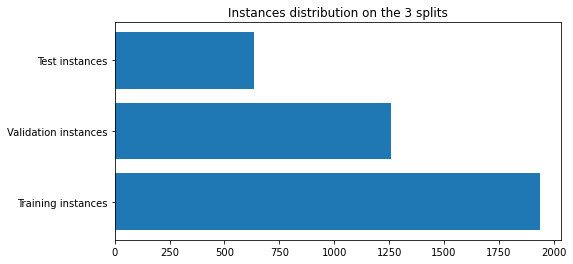

In [8]:
def plot_instances(train_size, val_size, test_size):
    x_values = [train_size, val_size, test_size]
    y_values = ["Training instances", "Validation instances", "Test instances"]
    y_axis = np.arange(1, 4, 1)
    plt.figure(figsize=(8,4))
    plt.title("Instances distribution on the 3 splits")
    plt.barh(y_axis, x_values, align='center')
    plt.yticks(y_axis, y_values)
    plt.show()

train_size = len(train_sentences)
val_size = len(val_sentences)
test_size = len(test_sentences)
print("There are {} training sentences".format(train_size))
print("There are {} validation sentences".format(val_size))
print("There are {} test sentences".format(test_size))

plot_instances(train_size, val_size, test_size)

Let's compute the average sentence length.

The average sentence length in the training set is 24.45919 with an std of 12.68342 and a max of 250
The average sentence length in the validation set is 24.82723 with an std of 11.93318 and a max of 88
The average sentence length in the test set is 24.44182 with an std of 10.02017 and a max of 80


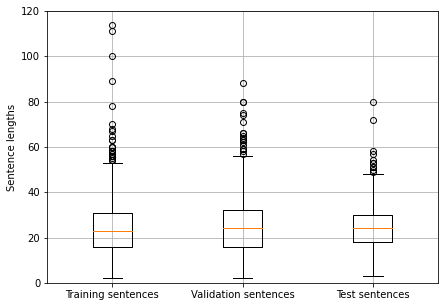

In [56]:
len_train = [len(sentence) for sentence in train_sentences]
len_val   = [len(sentence) for sentence in val_sentences  ]
len_test  = [len(sentence) for sentence in test_sentences ]

mean_train, std_train, max_train = np.mean(len_train), np.std(len_train), np.max(len_train)
mean_val, std_val, max_val = np.mean(len_val), np.std(len_val), np.max(len_val)
mean_test, std_test, max_test = np.mean(len_test), np.std(len_test), np.max(len_test)

print("The average sentence length in the training set is {:.5f} with an std of {:.5f} and a max of {}".format(
    mean_train, std_train, max_train
))
print("The average sentence length in the validation set is {:.5f} with an std of {:.5f} and a max of {}".format(
    mean_val, std_val, max_val
))
print("The average sentence length in the test set is {:.5f} with an std of {:.5f} and a max of {}".format(
    mean_test, std_test, max_test
))

len_dict = {'Training sentences':    len_train, 
            'Validation sentences':  len_val, 
            'Test sentences':        len_test}

fig, ax = plt.subplots(figsize=(7,5));
ax.boxplot(len_dict.values());
ax.set_xticklabels(len_dict.keys());
ax.set_ylim(0, 120)
ax.set_ylabel("Sentence lengths")
ax.grid()

The sentences seem to have approximately the same distribution between the three splits, but there are some clear outliers in the training set.

We also compute the distribution of the tags.

In [10]:
tags_distribution = pd.concat(train_sentences, axis=0).groupby(['tag']).count()
display(tags_distribution)


,word
tag,
#,1
$,342
'',398
",",2571
-LRB-,52
-RRB-,55
.,1959
:,293
CC,1141


Note: see [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) for the explanation of each tag. Some of the tags simply indicate punctuation.

In [11]:
PUNCTUATION_TAGS = ["#", "$", "''", ",", ".", ":", "``", "-LRB-", "-RRB-", "SYM"]
print("There are {} punctuation tags in the dataset".format(
    sum([ tags_distribution.loc[pun] for pun in PUNCTUATION_TAGS ])['word']
))

There are 6081 punctuation tags in the dataset


### Data Preprocessing

In this task, we don't want to remove words because we should provide a one-to-one mapping from words to tags.

Therefore, the only sensible preprocessing we can do on the sentences is to bring everything to lowercase.

TODO!!

In [12]:
def to_lower(word: str):
    return word.lower()

for sentence_group in [train_sentences, val_sentences, test_sentences]:
    for sentence in sentence_group:
        sentence['word'] = sentence['word'].apply(to_lower)

train_sentences[1]

,word,tag
18,mr.,NNP
19,vinken,NNP
20,is,VBZ
21,chairman,NN
22,of,IN
23,elsevier,NNP
24,n.v.,NNP
25,",",","
26,the,DT
27,dutch,NNP


## Embeddings

We download GloVe's pretrained embeddings with dimension 100 using the Gensim library.

In [13]:
def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads GloVe pre-trained word embedding model via gensim library.

    Parameters:
    - embedding_dimension: size of the embedding space to consider

    Returns:
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    assert embedding_dimension in {50,100,200,300}, "Embedding dimension must be one of 50,100,200,300"
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except:
        print("ERROR: No Internet connection available")
        return None
    return emb_model

EMBEDDING_DIMENSION = 100
embedding_model = load_embedding_model(EMBEDDING_DIMENSION)

### GloVe's vocabulary

We use as initial vocabulary the vocabulary of GloVe's pretrained embeddings.

In [14]:
embedding_vocabulary = set(embedding_model.index_to_key)
print("Starting vocabulary contains {} words.".format(len(embedding_vocabulary)))

Starting vocabulary contains 400000 words.


The vocabulary of the embeddings may not contain all the words that are used in our sentences, so we need to create sensible encodings for OOV words and add them to the vocabulary.

A smart idea to create OOV embeddings is to obtain the mean and standard deviation of the GloVe embeddings and to sample new random vectors from a reduced uniform distribution with those parameters. In this way, we make sure that OOV embeddings are at least similar to the real embeddings.

In [15]:
# Create an empty matrix that should hold all the embeddings of GloVe's vocabulary
def create_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors):
    embedding_vocabulary = set(embedding_model.index_to_key)
    embedding_matrix = np.zeros((len(embedding_vocabulary), EMBEDDING_DIMENSION), dtype=np.float32)

    # Loop through the words of the vocabulary
    for idx, word in tqdm(enumerate(embedding_model.index_to_key), total=len(embedding_vocabulary)):
        try:
            # Get the vector representation of the word according to the embedding model
            embedding_vector = embedding_model[word]
            # Set the corresponding row to the embedding vector
            embedding_matrix[idx] = embedding_vector
        except (KeyError, TypeError):
            pass
    
    return embedding_matrix

embedding_matrix = create_embedding_matrix(embedding_model)

# Calculate mean and standard deviation
glove_mean = embedding_matrix.mean()
glove_std = embedding_matrix.std()

print("Mean embedding vector: {}".format(glove_mean))
print("Std of embedding vectors: {}".format(glove_std))

100%|██████████| 400000/400000 [00:04<00:00, 94746.06it/s]


Mean embedding vector: 0.004451991990208626
Std of embedding vectors: 0.4081574082374573


Then we can define a function to create random embeddings for OOV words.

In [16]:
def get_random_embedding():
    return np.random.uniform(low=glove_mean-glove_std/10, 
        high=glove_mean+glove_std/10, size=EMBEDDING_DIMENSION
    )

### OOV terms

We find all OOV terms in the splits independently and build our vocabularies and embedding matrix. 

#### Training OOV terms

In [17]:
# Step 1: Obtain a set of words (vocabulary) used in each split
def get_set_of_words_for_sentences(sentence_seq: Sequence[pd.DataFrame]):
    return set(
        pd.concat(sentence_seq, axis=0).    # Concatenate all sentences together
        groupby(['word']).                  # Group by words
        indices.keys()                      # Obtain the sequence of words
    )             

train_vocabulary = get_set_of_words_for_sentences(train_sentences)
val_vocabulary = get_set_of_words_for_sentences(val_sentences)
test_vocabulary = get_set_of_words_for_sentences(test_sentences)

In [18]:
# Step 2: Find OOV words with respect to some vocabulary
def get_OOV_terms(vocab_1: set, vocab_2: set):
    return vocab_1.difference(vocab_2)

oov_train = get_OOV_terms(train_vocabulary, embedding_vocabulary)

print("DEBUG: Training set has {} OOV terms over {} total terms ({:.2f}%)".format(
    len(oov_train), len(train_vocabulary), len(oov_train)/len(train_vocabulary)*100
))
print("Some OOV terms:")
print(list(oov_train)[:30])

DEBUG: Training set has 359 OOV terms over 7402 total terms (4.85%)
Some OOV terms:
['biondi-santi', 'stock-index', 'war-rationed', '37-a-share', '62.625', '449.04', 'bell-ringer', 'uzi-model', 'sogo-shosha', 'electric-utility', 'cotran', 'ntg', '1.457', 'savers\\/investors', 'cash-rich', 'custom-chip', 'recession-inspired', '3,288,453', 'index-related', 'when-issued', 'pennview', '705.6', 'foreign-led', 'yen-denominated', 'drobnick', 'ctbs', 'school-board', '382-37', 'replacement-car', 'buttoned-down']


OOVs (for the training set) seem to mostly be: 
- hyphenated compound words
- numbers
- foreign words
- other uncommon words

We update the vocabulary adding these OOV words.

In [19]:
embedding_model.add_vectors(list(oov_train), 
    np.stack([get_random_embedding() for _ in range(len(oov_train))])
)
train_embedding_vocabulary = set(embedding_model.index_to_key)

print("New length of the embedding model: {}".format(len(train_embedding_vocabulary)))

New length of the embedding model: 400359


We repeat the process for the evaluation and test sets.

#### Validation OOV terms

In [20]:
# Find OOV words
oov_val = get_OOV_terms(val_vocabulary, train_embedding_vocabulary)
print("DEBUG: Validation set has {} OOV terms over {} total terms ({:.2f}%)".format(
    len(oov_val), len(val_vocabulary), len(oov_val)/len(val_vocabulary)*100
))
print("Some OOV terms:")
print(list(oov_val)[:30])

# Update the model
embedding_model.add_vectors(list(oov_val), 
    np.stack([get_random_embedding() for _ in range(len(oov_val))])
)
val_embedding_vocabulary = set(embedding_model.index_to_key)

print("New length of the embedding model: {}".format(len(val_embedding_vocabulary)))

DEBUG: Validation set has 189 OOV terms over 5420 total terms (3.49%)
Some OOV terms:
['pension-fund', 'mutual-fund', 'band-wagon', 'super-absorbent', 'anku', '95.09', 'house-senate', 'million-a-year', 'write-downs', 'melt-textured', '12\\/32', 'property\\/casualty', 'seven-million-ton', 'foldability', '1738.1', 'diceon', 'gates-warren', 'one-house', 'express-buick', 'price-depressing', 'walbrecher', 'profit-taking', 'scypher', 'anti-program', 'much-larger', 'labor-backed', 'sidak', 'credit-rating', 'motor-home', 'stock-selection']
New length of the embedding model: 400548


#### Test OOV terms

In [21]:
# Find OOV words
oov_test = get_OOV_terms(test_vocabulary, val_embedding_vocabulary)
print("DEBUG: Test set has {} OOV terms over {} total terms ({:.2f}%)".format(
    len(oov_test), len(test_vocabulary), len(oov_test)/len(test_vocabulary)*100
))
print("Some OOV terms:")
print(list(oov_test)[:30])

# Update the model
embedding_model.add_vectors(list(oov_test), 
    np.stack([get_random_embedding() for _ in range(len(oov_test))])
)
test_embedding_vocabulary = set(embedding_model.index_to_key)

print("New length of the embedding model: {}".format(len(test_embedding_vocabulary)))

DEBUG: Test set has 128 OOV terms over 3407 total terms (3.76%)
Some OOV terms:
['newspaper-printing', '434.4', 'copper-rich', '170,262', 'tete-a-tete', '43.875', 'blue-chips', '372.14', '608,413', 'early-retirement', 'pro-iranian', 'heavy-truck', '1206.26', '142.84', '1.916', 'manmade-fiber', '11,390,000', 'shareholder-rights', 'derchin', 'inter-tel', 'hasbrouk', 'bread-and-butter', '734.9', '83,206', 'yoshihashi', '40-megabyte', 'near-limit', 'intelogic', '38.875', '5,699']
New length of the embedding model: 400676


#### Summary

In general, we notice the same pattern we have exposed for training OOV terms also in the OOV of the other splits. 

Additionally, we report that the number of OOV terms is always less than 5% in all splits, so they shouldn't be a big problem.

### Padding

It's time to think some steps ahead: when we feed our sentences to the model, we usually provide mini-batches of data (for example, a set of 128 sentences at a time). This makes training faster and more stable.

A mini-batch of data should be "rectangular", meaning that sentences should all have the same number of words. Usually, this translates to using **padding** in the sentences, filling the vectors representing the sentences with zeroes up to a predetermined size.

In [25]:
embedding_model.add_vector('<PAD>', np.zeros(EMBEDDING_DIMENSION)); # The embedding is a vector of zeroes

We should check what the index of the padding vector is.

In [29]:
PADDING_IDX = embedding_model.key_to_index['<PAD>']
PADDING_IDX

400676

We would like to have the padding token as element 0 (because it can be automatically masked when using [Keras's Embedding Layer](https://keras.io/api/layers/core_layers/embedding/)).

### Final embedding matrix

In [43]:
embedding_matrix = create_embedding_matrix(embedding_model)
# We need to move the row where the padding index is at the first row and shift the rest of the matrix by 1
embedding_matrix = np.append(embedding_matrix[-1:, :], embedding_matrix[:-1, :], axis=0)
print("DEBUG: Embedding matrix shape: {}".format(embedding_matrix.shape))

100%|██████████| 400677/400677 [00:02<00:00, 154921.87it/s]


DEBUG: Embedding matrix shape: (400677, 100)


## Baseline model

As a baseline model, we create a network composd by a (non-trainable) Embedding layer, a single Bidirectional LSTM layer and a Time-Distributed Dense layer on top.

### Dataset processing pipeline

First of all, though, we should provide some utility functions to facilitate inputting data to the networks.

We have decided to use TensorFlow's [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) class, since it provides many useful functions for dealing with batches and building efficient data preprocessing pipelines.

In [45]:
# A function that converts a sentence to a list of indices indexing the created vocabulary model
def sentence_to_idxs(sentence: pd.DataFrame):
    sentence_list = get_list_of_words_from_sentence(sentence)
    return [ embedding_model.key_to_index[word] + 1 for word in sentence_list ] # +1 for padding

print("DEBUG: indexes for sentence '{}':".format(get_natural_language_sentence(train_sentences[1])))
sentence_to_idxs(train_sentences[1])

DEBUG: indexes for sentence 'mr. vinken is chairman of elsevier n.v. , the dutch publishing group .':


[1996, 400059, 15, 664, 4, 43651, 60024, 2, 1, 1693, 3649, 130, 3]

We apply this function to the entire dataset splits.

In [46]:
X_train = [ sentence_to_idxs(sentence) for sentence in train_sentences ]
X_val   = [ sentence_to_idxs(sentence) for sentence in val_sentences   ]
X_test  = [ sentence_to_idxs(sentence) for sentence in test_sentences  ]

We use [a Tensorflow function](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) to automatically apply padding to the sequences.

In theory, padding should bring all tensors to have as many elements as the longest sentence. We have analyzed before that the training set has some outliers and the longest sequence contains 250 elements, but bringing all sequences to have 250 elements is clearly a waste of memory.

Instead, **only for the training set**, we choose to fix a maximum length similar to the other splits. This will cut a part of the outlier sentences, but since they are only used for training it shouldn't be a big problem.

In [68]:
np.quantile(len_train, 0.99751) # If we choose 80 as maximum length (similar to the other splits), 
                                # we avoid to cut over 99.75% of the sentences.

80.00034999999934

In [70]:
X_train = keras.preprocessing.sequence.pad_sequences(
    X_train, maxlen=80, truncating='post'   # truncating='post' means that we cut the last part of the sentence
)

X_val = keras.preprocessing.sequence.pad_sequences(X_val) # No cutting
X_test = keras.preprocessing.sequence.pad_sequences(X_test) # No cutting

# TODO: We also need to encode labels and add them to the datasets below

In [78]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(BATCH_SIZE)

## Experiments

## Evaluation

## Error Analysis